

<font face="B Mitra" size=4>

<div dir="rtl">
<b></b>
ابتدا 
transform
را می سازیم که تا تصاویر را به به تنسور تبدیل کن تا بتوانیم در شبکه عصبی از آن ها استفاده کنیم.
سپس دو قسمت
train
و
test
را می سازیم و از دیتا ست 
mnist
دانلود می کنیم و 
transform 
را به آن می دهیم تا داده هارا به 
tensor
تبدیل کند.
.
train_loader
و
test_loader
را می سازیم که بتوانیم از آن ها برای آموزش و تست شبکه عصبی استفاده کنیم.
به این صورت که تصویر هارا به صورت بچ 32 تایی به صورت شافل شده در لودر لود می کند.

</font>





In [21]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform,download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)




<font face="B Mitra" size=4>

<div dir="rtl">
<b></b>
در این قسمت کلاس
Autoencoder
را می سازیم که شبکه عصبی ما را تعریف می کند.
این شبکه عصبی دو بخش دارد
encoder
و
decoder
که 
encoder
از سه لایه 
convolutional
تشکیل شده است که 
stride
و
padding
و
kernel_size
را طوری تنظیم می کنیم که تصویر 
1*28*28
را به تصویر
64*1*1
تبدیل کند.
و انگار تصویر به 
64
پیکسل کوچک شده است.
سپس این قسمت
latent
تشکیل شده را به 
decoder
می دهد که از سه لایه
convolutional_transpose
تشکیل شده است که 
latent
را گرفته و با بزرگ کردن آن را به همان تصویر اولیه آن
1*28*28
تبدیل می کند.
بعد از هر لایه از
convolutional
در
encoder
از 
ReLU
استفاده کردیم وهمچنین بعد از هر لایه از
convolutional_transpose
در
decoder
از
ReLU
استفاده کردیم.
و 
forward
را می سازیم که تصویر را از
encoder
گرفته و به 
latent space
می برد و 
decoder
در 
forward
از
latent
گرفته و تصویر را به تصویر اولیه بر می گرداند. 
</font>





In [22]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



<font face="B Mitra" size=4>

<div dir="rtl">
<b></b>

در این قسمت  تابعی را پیاده سازی کرده ایم که 
image
،
index
ام را از ده بچ در تست می گیرد و تصویر اصلی در مقایسه با 
encoder 
و
سپس
decoder
گرفتن از آن مقایسه می کند که چطور عمل می کند.


</font>





In [23]:
def show_image(test_loader, autoencoder,label,index=0):
    input_images = []
    output_images = []
    for i, (images, _) in enumerate(test_loader):
        input_images.append(images[index])
        reconstructed_images = autoencoder(images)
        output_images.append(reconstructed_images[0])
        if i == 10:
            break
    fig, axs = plt.subplots(2, 10, figsize=(20, 4))
    # tatal plot label
    fig.suptitle(label)
    for i in range(10):
        axs[0, i].imshow(input_images[i].squeeze(), cmap='gray')
        axs[0, i].set_title(f'Input{i+1}')
        axs[0, i].axis('off')
        axs[1, i].imshow(output_images[i].squeeze().detach().numpy(), cmap='gray')
        axs[1, i].set_title(f'Output{i+1}')
        axs[1, i].axis('off')
    plt.show()



<font face="B Mitra" size=4>

<div dir="rtl">
<b></b>

ایجا ده تصویر در مقایسه با حالت بعد از عبور از 
Autoencoder
آن ها قبل از 
Train
را مشاهده می کنیم.

</font>





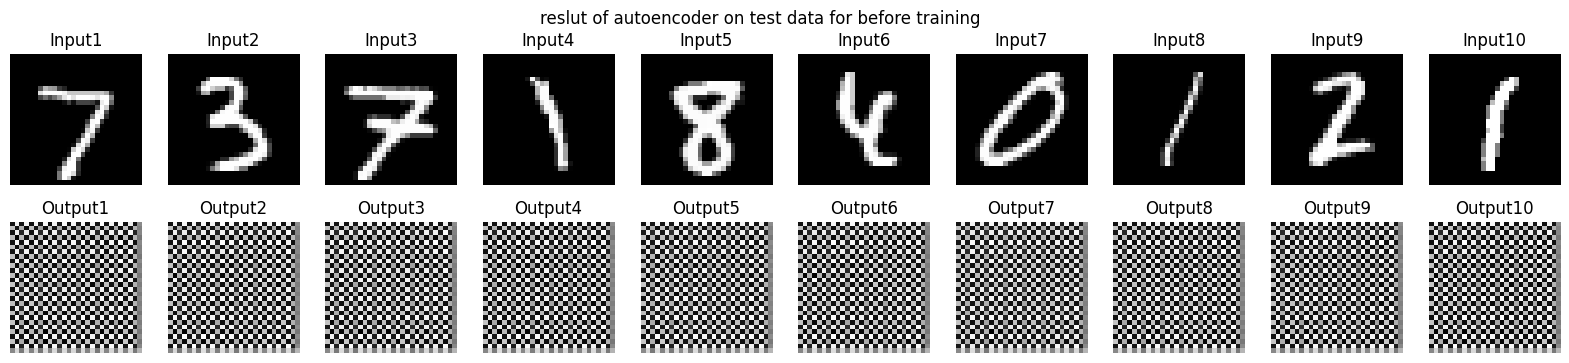

In [24]:
autoencoder = Autoencoder()
label = 'reslut of autoencoder on test data for before training'
show_image(test_loader, autoencoder,label)



<font face="B Mitra" size=4>

<div dir="rtl">
<b>Train</b>
<br>
ابتدا 
autoencoder
,
criterion
که همان
MSE
هست و
optimizer
را از نوع 
Adam
با لرنینگ ریت 0.001
می سازیم.
و به تعداد سه 
epoch
مدل را آموزش می دهیم.
مشاهده می کنیم که 
loss
کاهش می یابد.
در نهایت خروجی از 
autoencoder
را در مقایسه با تصویر اصلی به نمایش می گذاریم می بینیم که با دقت بالایی شبیه به همدیگر هستند. 

در هر ایپاک به تعداد بچ ها فور می زنیم و در هر بچ داده های آن بچ را دریافت کرده تصویر را از 
autoencoder
عبور داده و 
reconstructied_image
را می سازیم و
loss
را با مقایسه تصاویر اولیه آن ها و 
reconstructied_image
که خروجی
autoencoder
است محاسبه می کنیم 
وپس از صفر کردن گرادیان ها و محاسبه گرادیان ها با استفاده از
backward با استفاده از
optimizer
پارامتر های مدل را به روز رسانی می کنیم.


همچنین چک میکند که اگر 
Gpu
در دسترس است از 
Gpu
برای محاسبات استفاده کند.


<b>ابر پارامتر ها</b>
<br>
ابر پارامتر هاراکه شامل 
epoch_num
,
learning rate
و
batch_size
هست را به ترتیب برابر:
3
,
0.001
و
32
قرار داده ایم.

</font>





Epoch [1/10], Step [100/1875], Loss: 0.0717
Epoch [1/10], Step [200/1875], Loss: 0.0670
Epoch [1/10], Step [300/1875], Loss: 0.0349
Epoch [1/10], Step [400/1875], Loss: 0.0257
Epoch [1/10], Step [500/1875], Loss: 0.0174
Epoch [1/10], Step [600/1875], Loss: 0.0147
Epoch [1/10], Step [700/1875], Loss: 0.0142
Epoch [1/10], Step [800/1875], Loss: 0.0121
Epoch [1/10], Step [900/1875], Loss: 0.0125
Epoch [1/10], Step [1000/1875], Loss: 0.0094
Epoch [1/10], Step [1100/1875], Loss: 0.0085
Epoch [1/10], Step [1200/1875], Loss: 0.0088
Epoch [1/10], Step [1300/1875], Loss: 0.0089
Epoch [1/10], Step [1400/1875], Loss: 0.0069
Epoch [1/10], Step [1500/1875], Loss: 0.0079
Epoch [1/10], Step [1600/1875], Loss: 0.0073
Epoch [1/10], Step [1700/1875], Loss: 0.0066
Epoch [1/10], Step [1800/1875], Loss: 0.0078
Epoch [2/10], Step [100/1875], Loss: 0.0057
Epoch [2/10], Step [200/1875], Loss: 0.0065
Epoch [2/10], Step [300/1875], Loss: 0.0062
Epoch [2/10], Step [400/1875], Loss: 0.0062
Epoch [2/10], Step [500

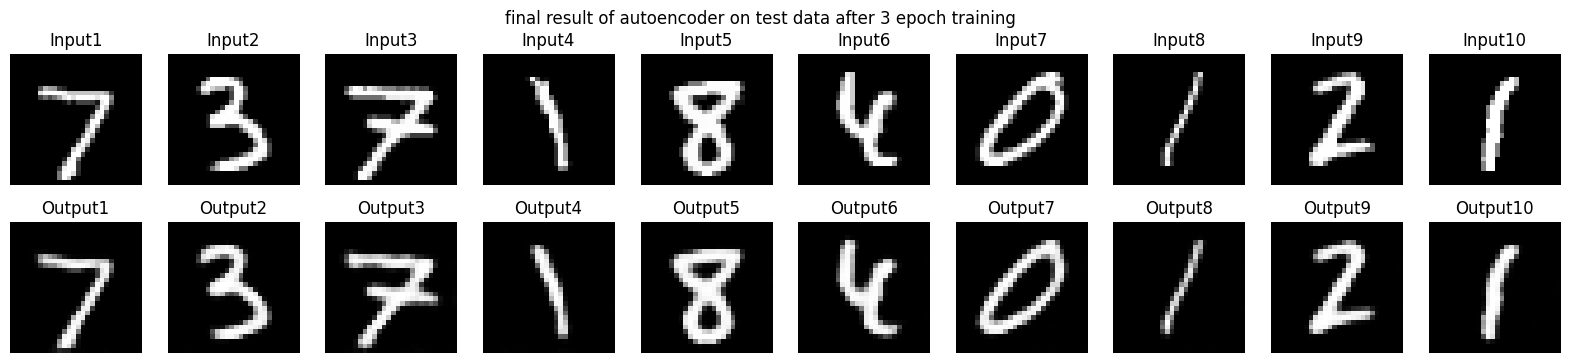

In [25]:
autoencoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

num_epochs = 3


for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        images = images.to('cuda' if torch.cuda.is_available() else 'cpu')

        reconstructed_images = autoencoder(images)

        loss = criterion(reconstructed_images, images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, 10, i + 1, len(train_loader), loss.item()))
label = "final result of autoencoder on test data after 3 epoch training"
show_image(test_loader, autoencoder,label)



<font face="B Mitra" size=4>

<div dir="rtl">
<b></b>

روند اموزش به ازای 
6
بچ اول در ایپاک اول مشاهده می کنیم.

</font>





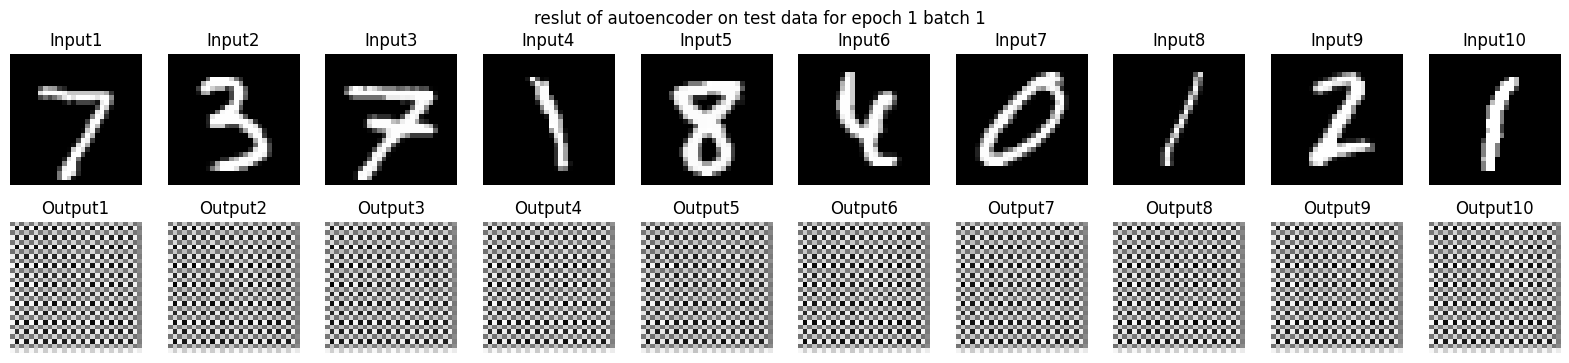

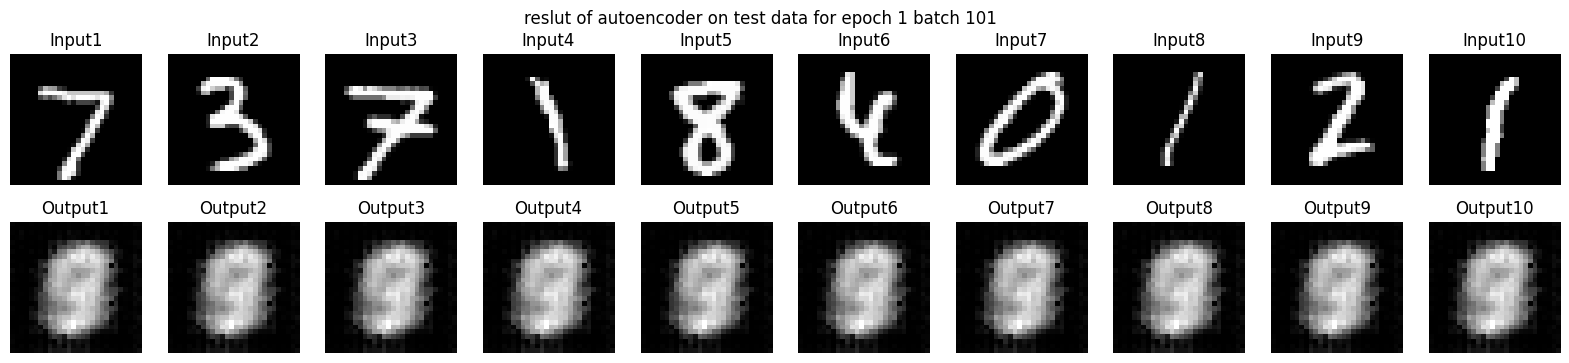

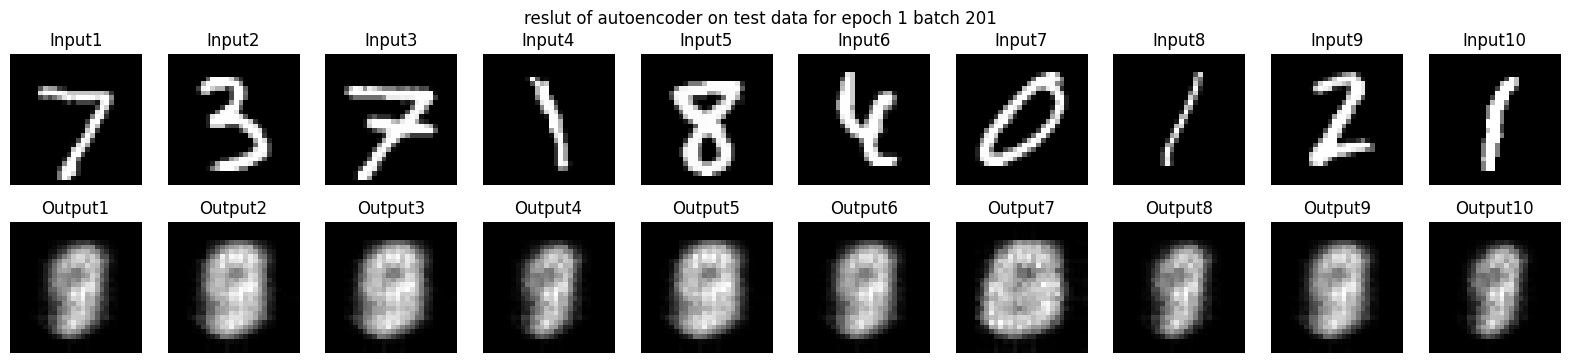

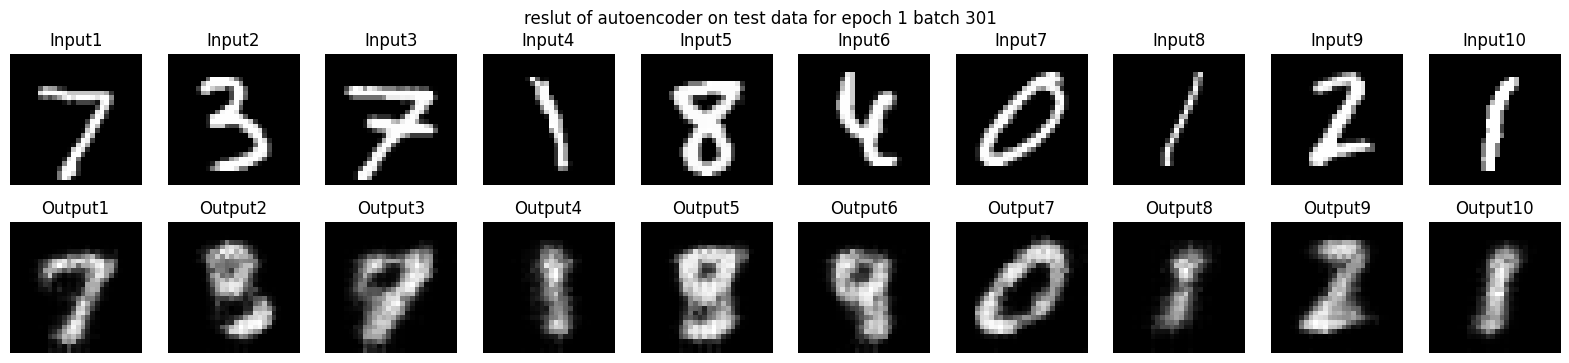

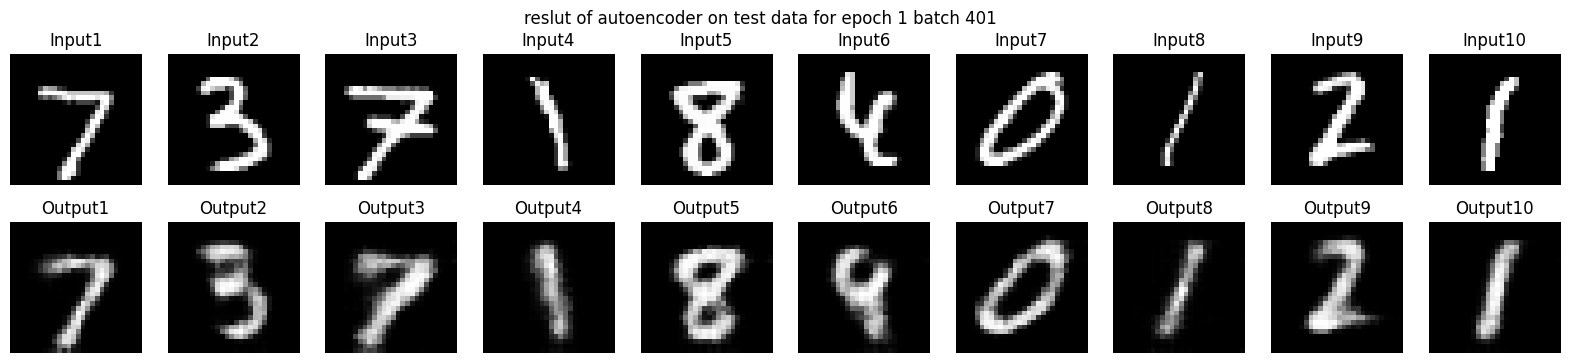

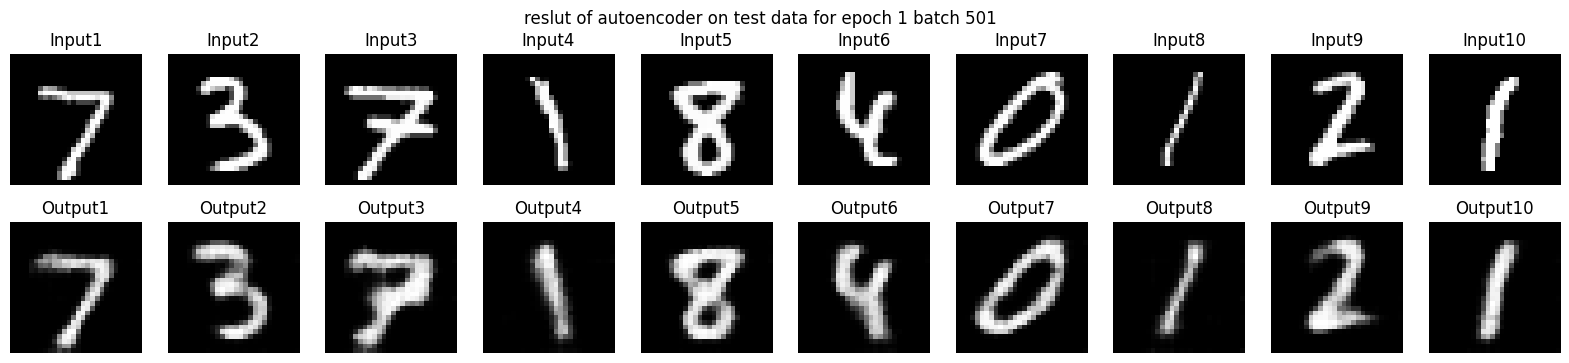

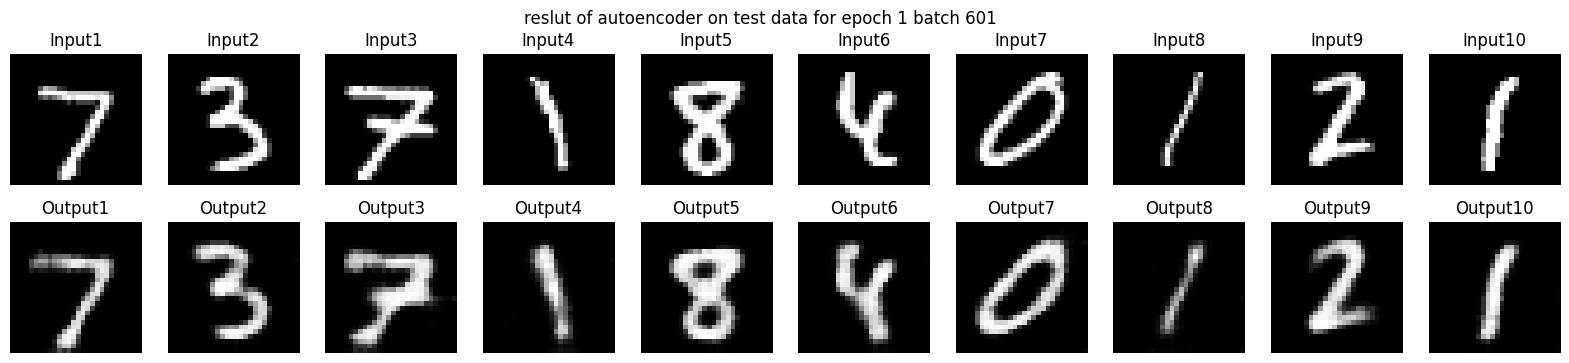

In [26]:
autoencoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

num_epochs = 1


for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        images = images.to('cuda' if torch.cuda.is_available() else 'cpu')

        reconstructed_images = autoencoder(images)

        loss = criterion(reconstructed_images, images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch == 0 and (i) % 100 == 0 and i<700:
            label = f'reslut of autoencoder on test data for epoch {epoch+1} batch {i+1}'
            show_image(test_loader, autoencoder,label)
        



<font face="B Mitra" size=4>

<div dir="rtl">
<b></b>

روند آموزش در 2 بچ اخر ایپاک سوم مشاده می کنیم.

</font>





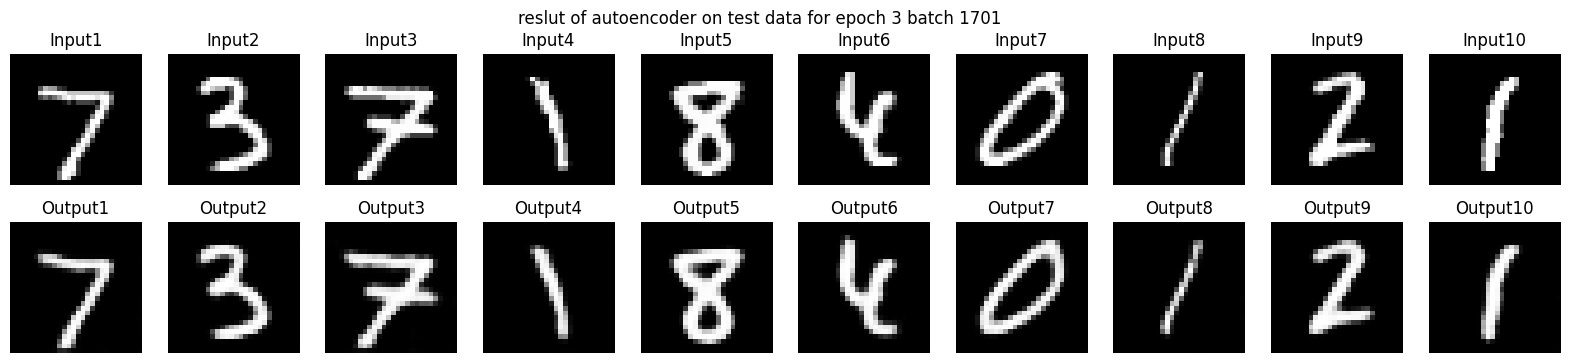

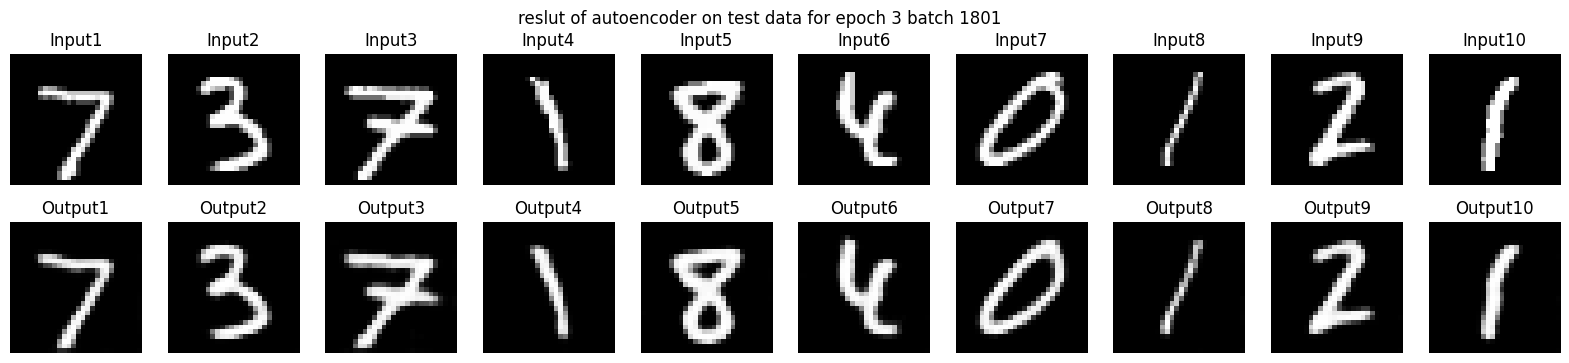

In [27]:
autoencoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

num_epochs = 3


for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        images = images.to('cuda' if torch.cuda.is_available() else 'cpu')

        reconstructed_images = autoencoder(images)

        loss = criterion(reconstructed_images, images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch == 2 and (i) % 100 == 0 and i>1600:
            label = f'reslut of autoencoder on test data for epoch {epoch+1} batch {i+1}'
            show_image(test_loader, autoencoder,label)



<font face="B Mitra" size=4>

<div dir="rtl">
<b></b>

تابع
show_image2
را برای دو کلاس
encoder
و
decoder
تغییر می دهیم.

</font>





In [28]:
def show_image2(test_loader, encoder,decoder,label,index=0):
    input_images = []
    output_images = []
    for i, (images, _) in enumerate(test_loader):
        input_images.append(images[index])

        encoded_images = encoder(images)
        reconstructed_images = decoder(encoded_images)
        
        output_images.append(reconstructed_images[0])
        if i == 10:
            break
    fig, axs = plt.subplots(2, 10, figsize=(20, 4))
    # tatal plot label
    fig.suptitle(label)
    for i in range(10):
        axs[0, i].imshow(input_images[i].squeeze(), cmap='gray')
        axs[0, i].set_title(f'Input{i+1}')
        axs[0, i].axis('off')
        axs[1, i].imshow(output_images[i].squeeze().detach().numpy(), cmap='gray')
        axs[1, i].set_title(f'Output{i+1}')
        axs[1, i].axis('off')
    plt.show()



<font face="B Mitra" size=4>

<div dir="rtl">
<b></b>

حالت دیگری را پیاده سازی می کیم که در آخر 
encoder
و در ابتدای
decoder
تعدادی
linear
به شبکه اضافه کنیم.
که باعث پیچیده تر شدن شبکه میشود و دیر تر پیدا می کند اما الگو های پیچیده تر را می تواند تشخیص دهد.
روند یادگیری را نیز مشاهده می کنیم که کند تر است.
و بعد دو ایپاک کاملا مطابقت ندارد.

</font>





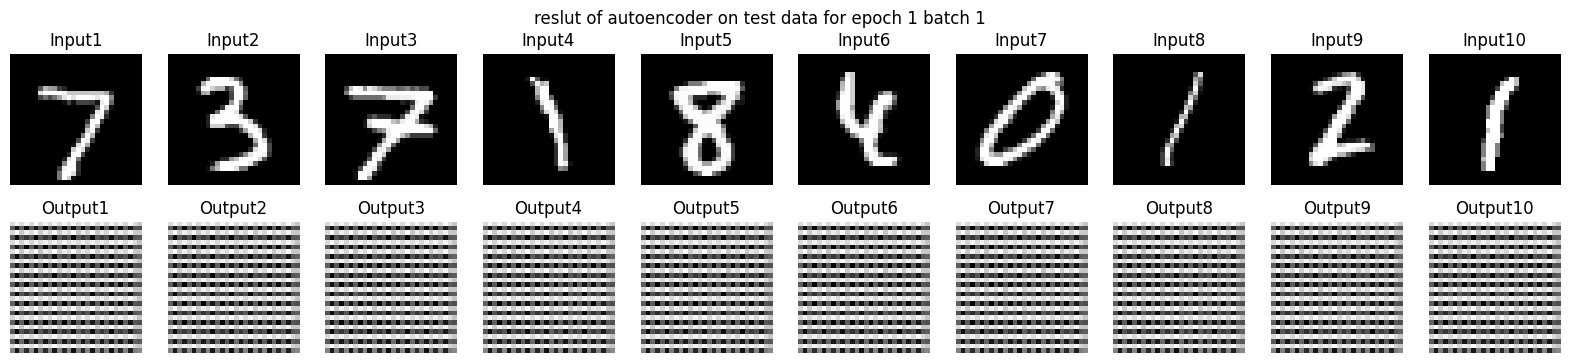

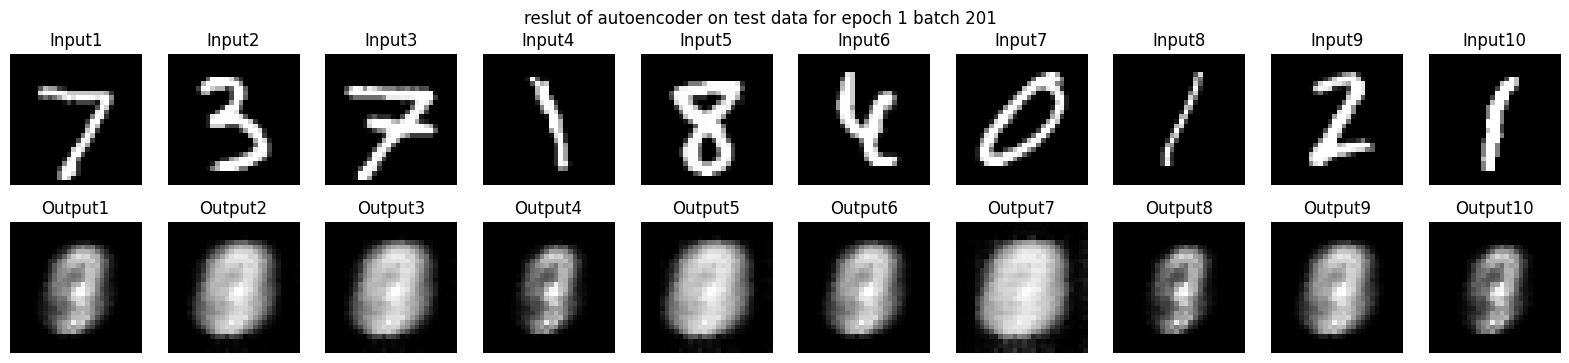

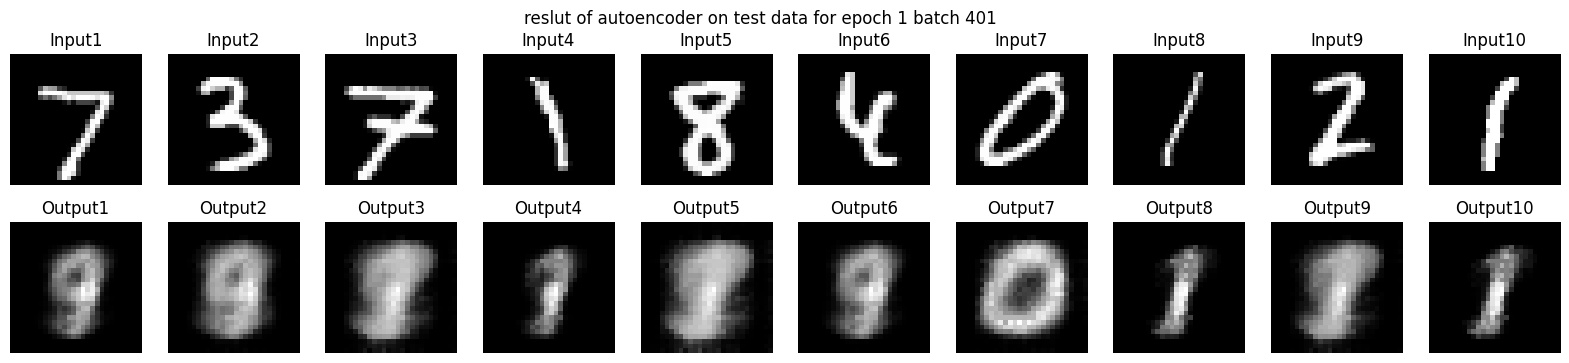

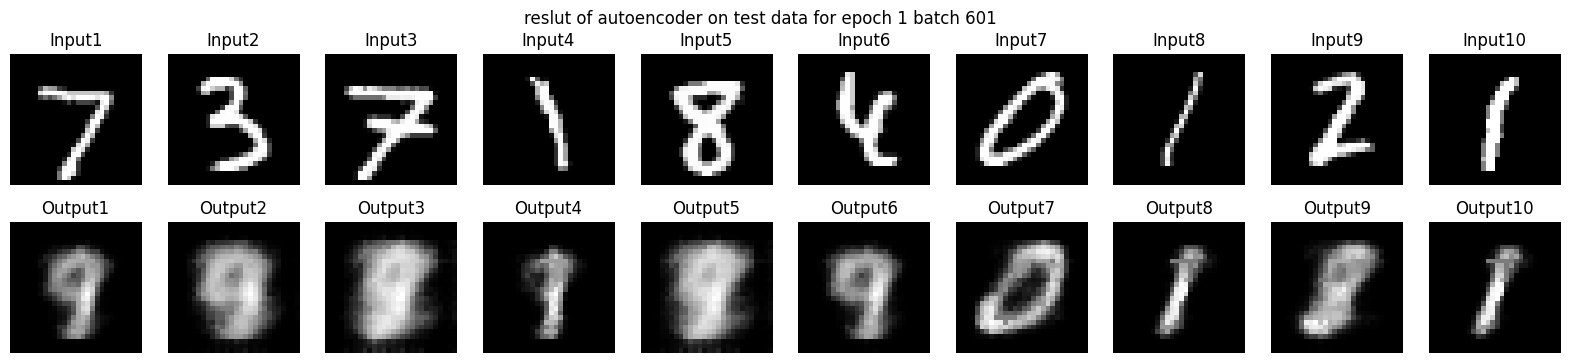

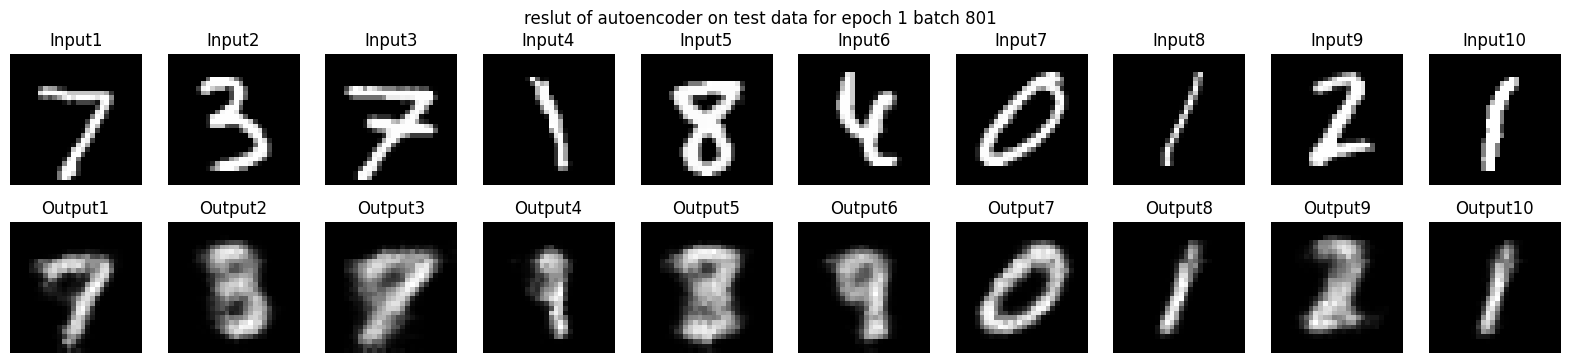

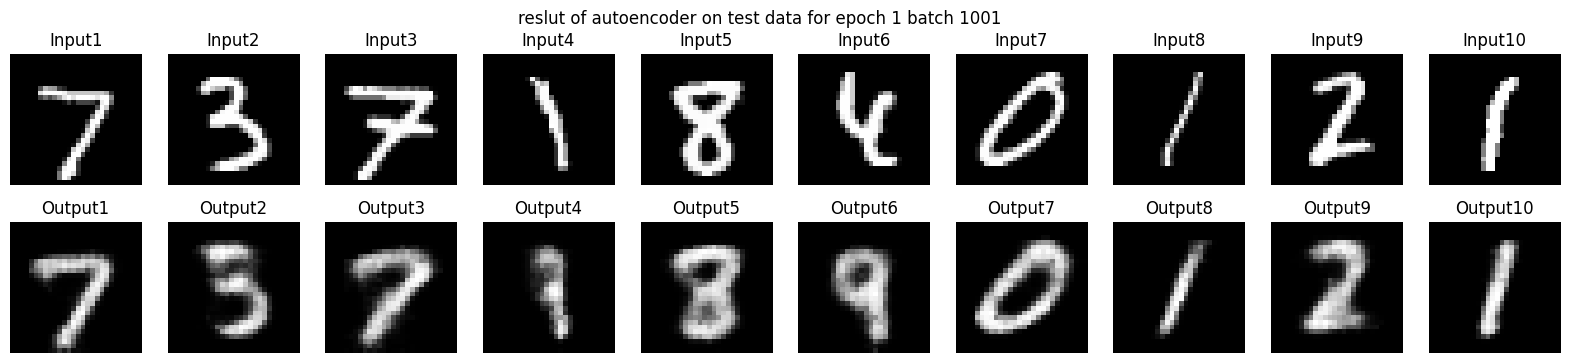

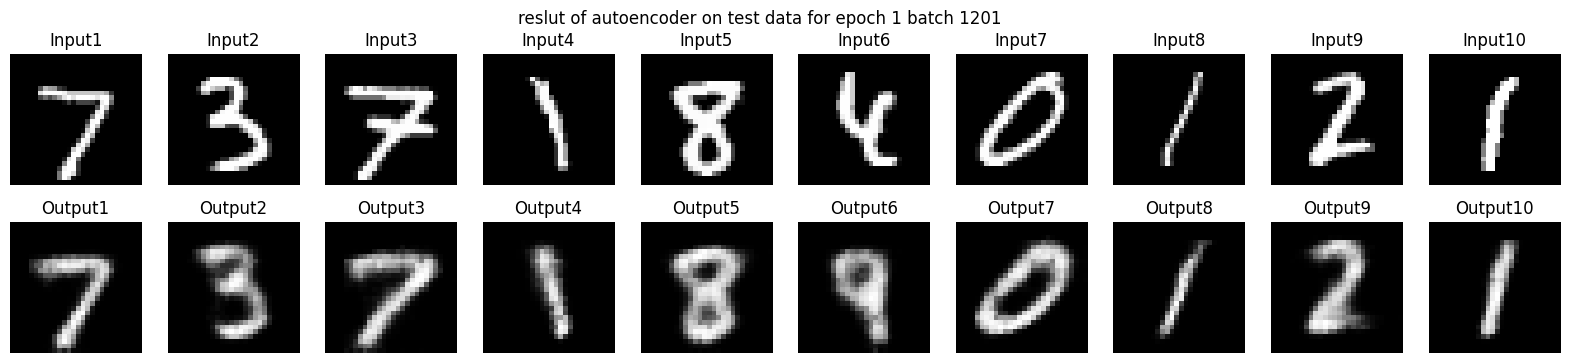

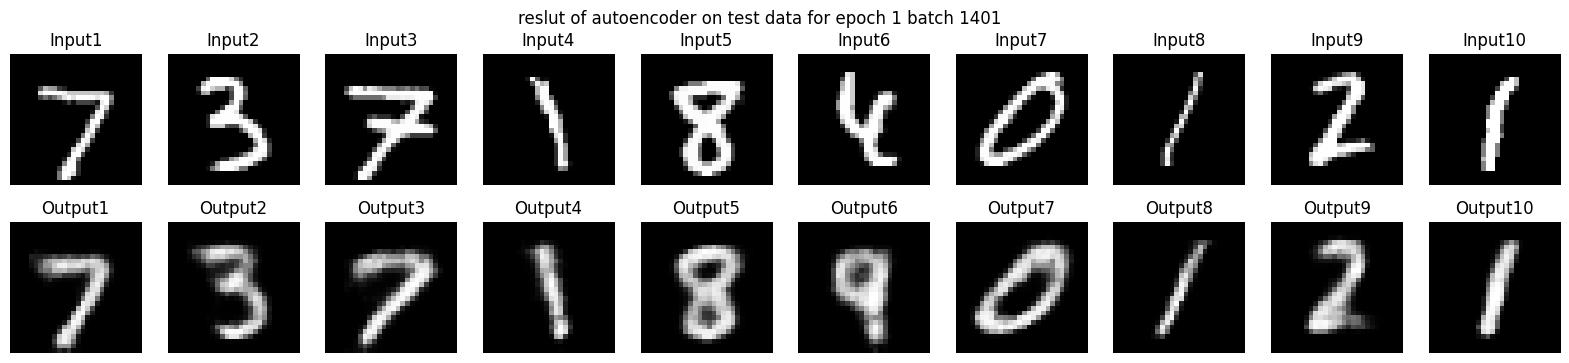

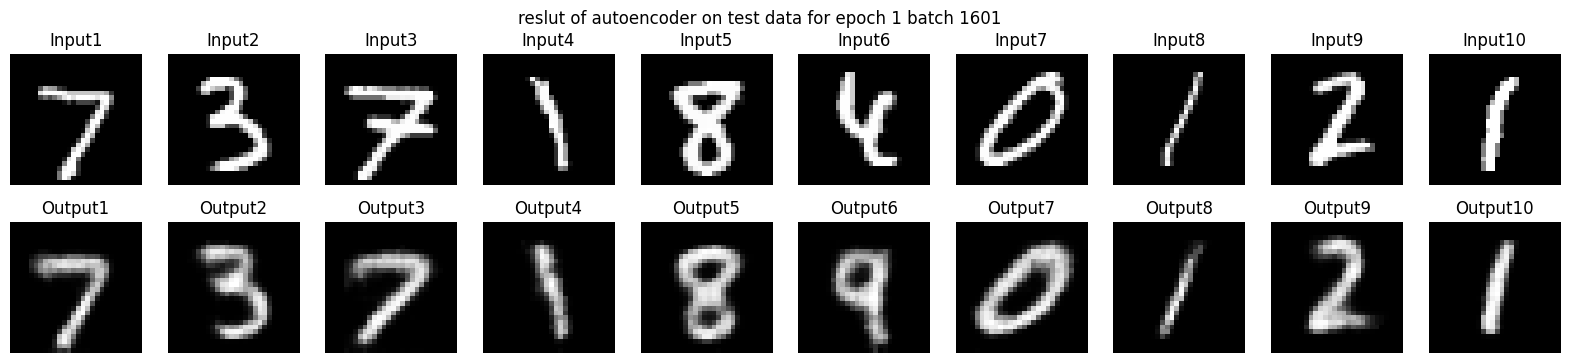

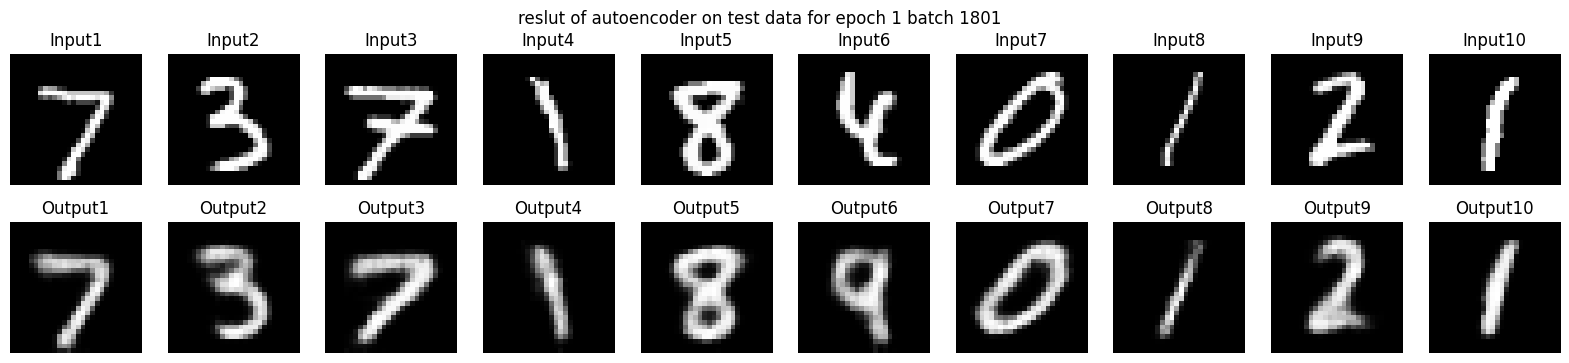

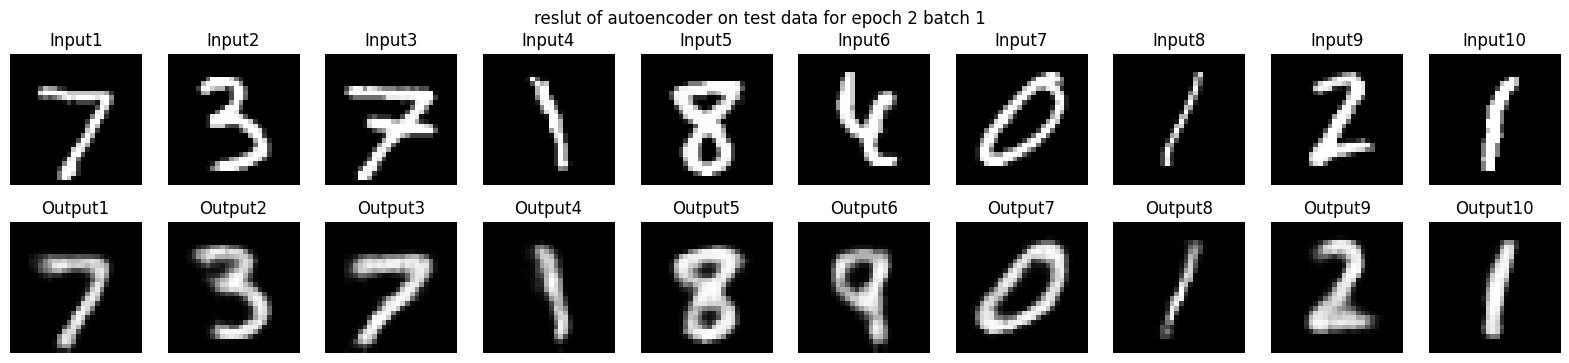

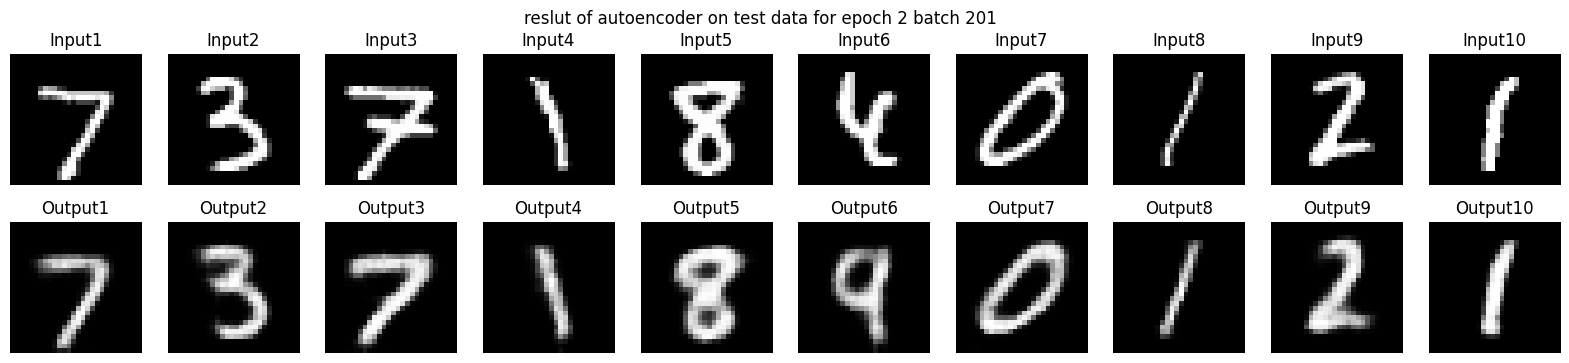

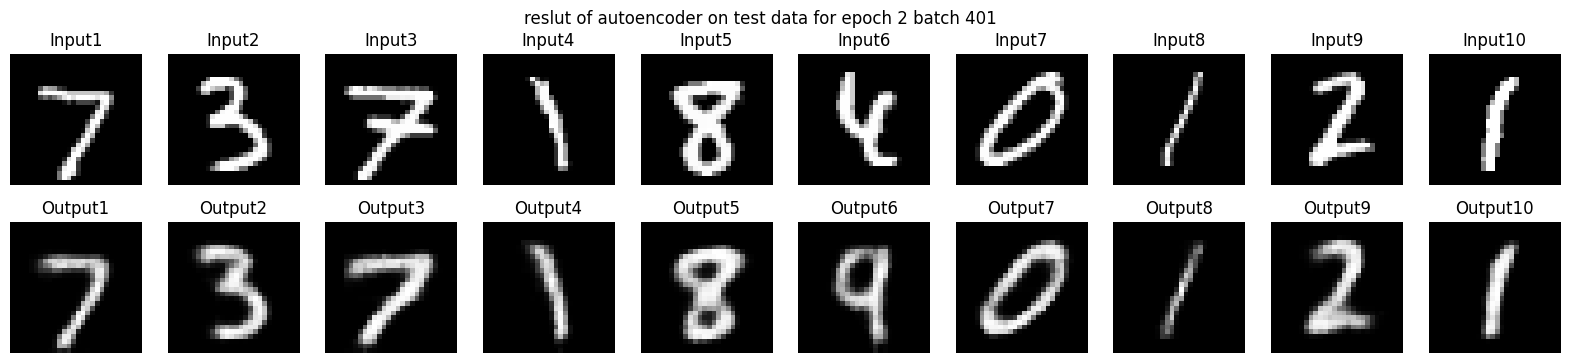

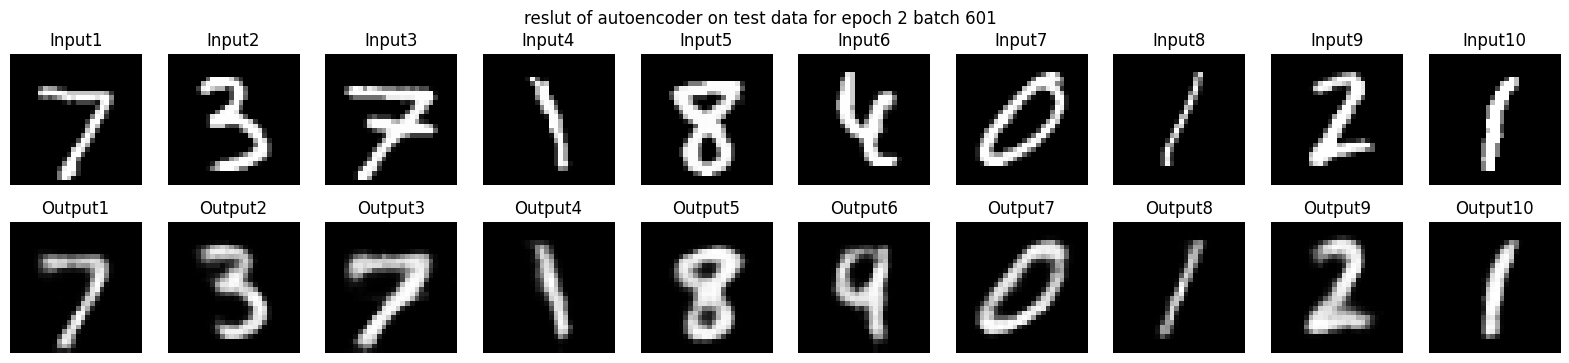

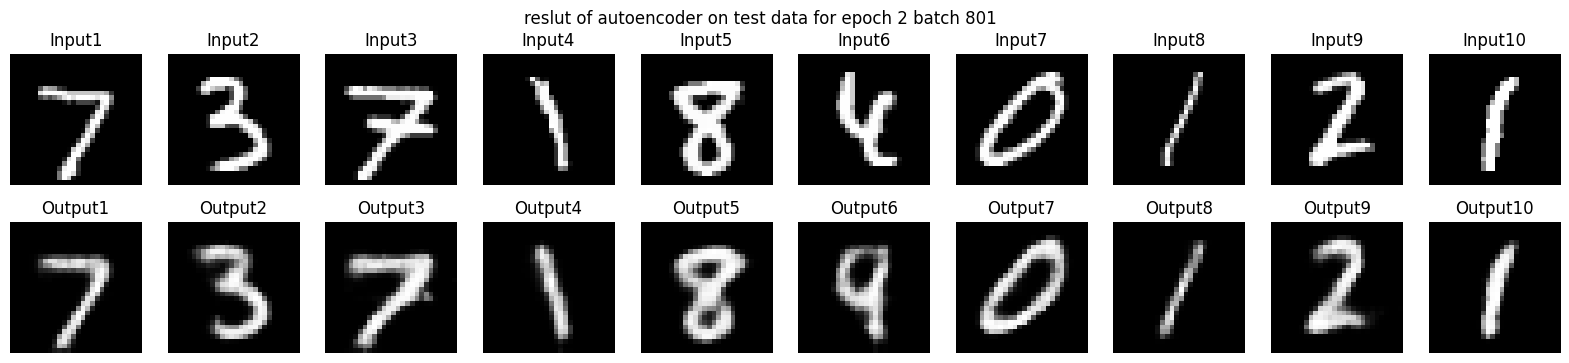

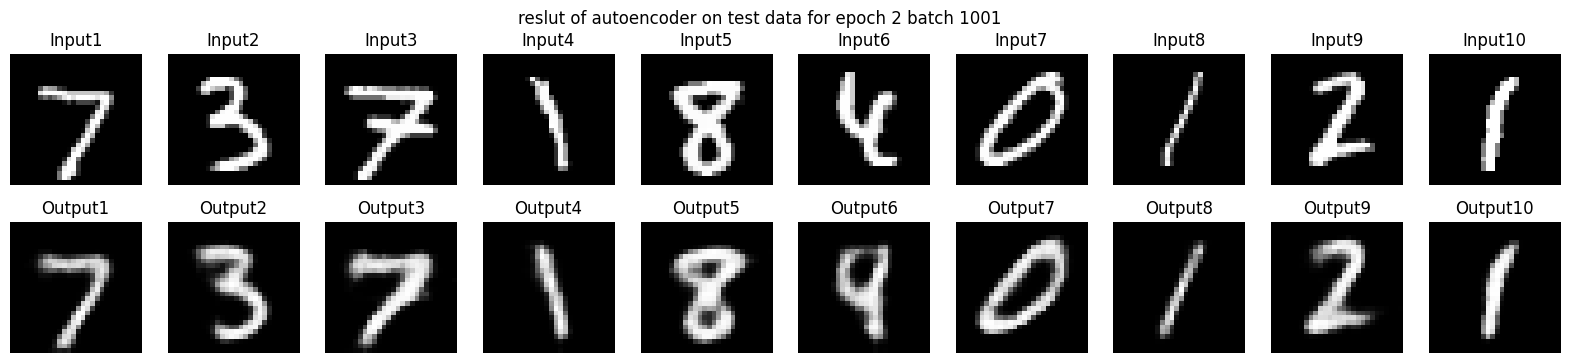

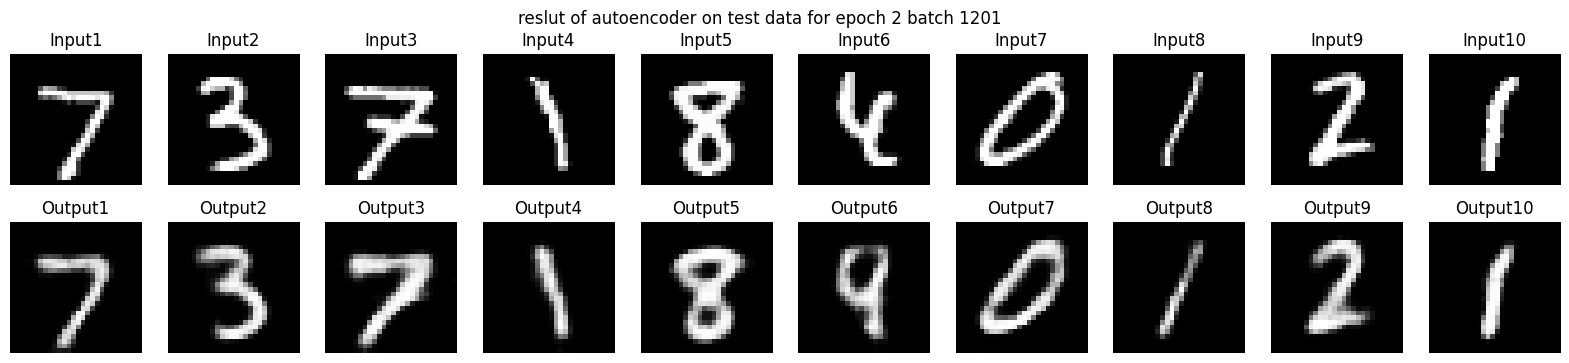

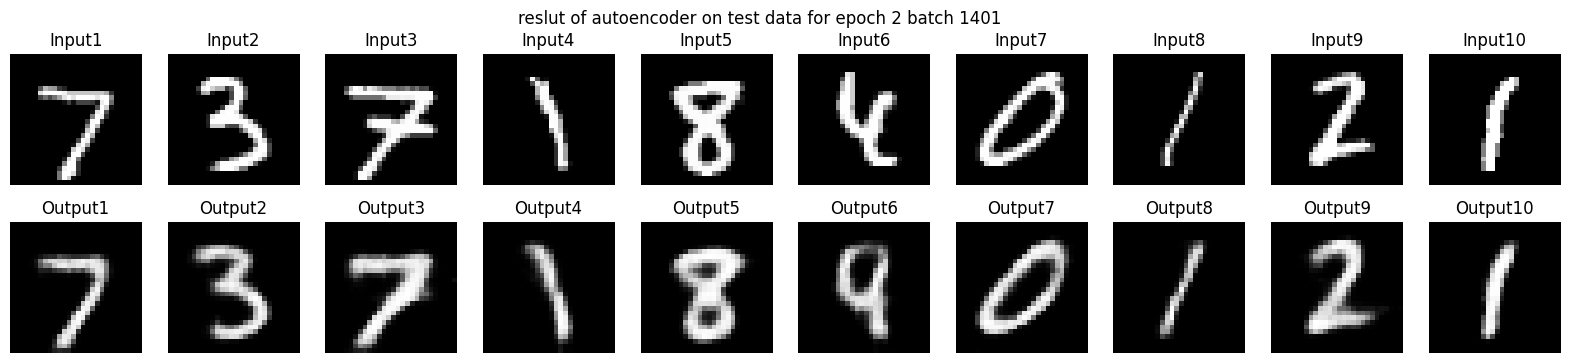

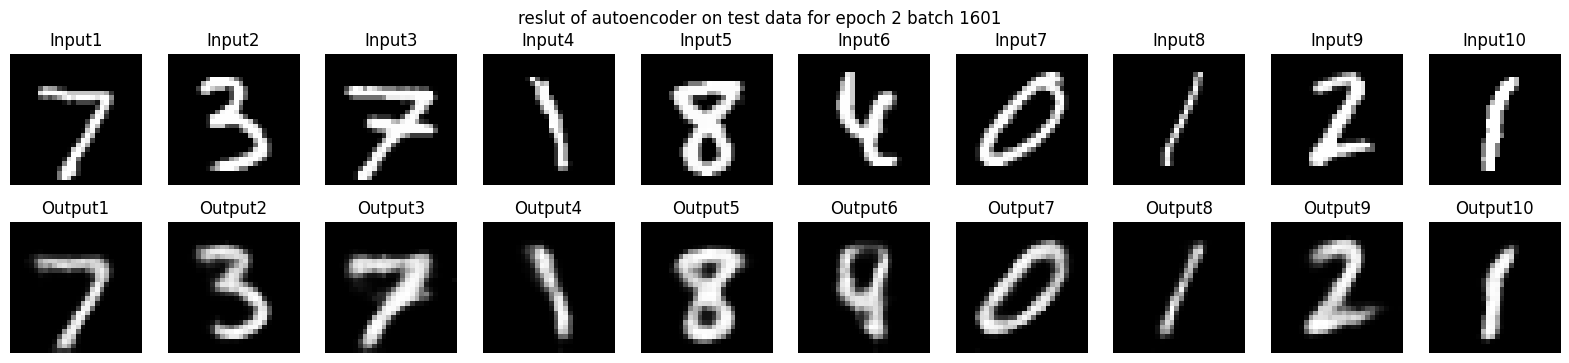

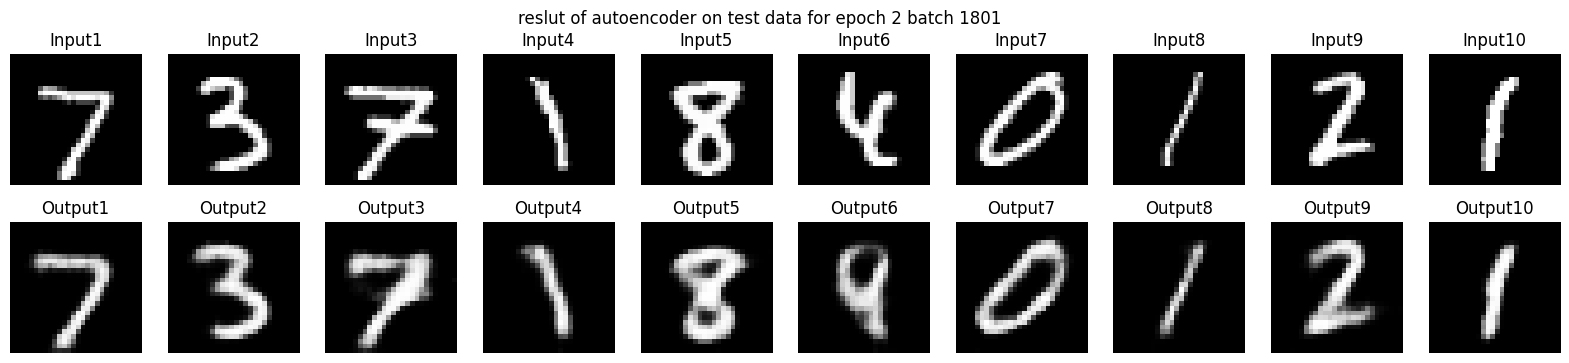

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # 1*28*28 -> 16*14*14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 16*14*14 -> 32*7*7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)  # 32*7*7 -> 64*1*1
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*1*1, 128) 
        self.fc2 = nn.Linear(128, 64)  

    def forward(self, x):
        x = self.encoder_conv(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        return x


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 64*1*1)
        self.unflatten = nn.Unflatten(1, (64, 1, 1))
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),  # 64*1*1 -> 32*7*7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # 32*7*7 -> 16*14*14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # 16*14*14 -> 1*28*28
            nn.Sigmoid() 
        )

    def forward(self, x):
        x = self.fc3(x)
        x = nn.ReLU()(x)
        x = self.fc4(x)
        x = nn.ReLU()(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        return x

encoder = Encoder()
decoder = Decoder()

criterion = nn.MSELoss()
optimizer = optim.Adam(lr=0.001, params=list(encoder.parameters()) + list(decoder.parameters()))

epoch_num = 2
for epoch in range(epoch_num):
    for i, (images, _) in enumerate(train_loader):
        images = images.to('cuda' if torch.cuda.is_available() else 'cpu')

        encoded_images = encoder(images)
        reconstructed_images = decoder(encoded_images)

        loss = criterion(reconstructed_images, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        if (i) % 200 == 0 and (not epoch == 2 or  i>1000):
            label = f'reslut of autoencoder on test data for epoch {epoch+1} batch {i+1}'
            show_image2(test_loader, encoder,decoder,label)